# MedleyVox Artist Recognition
This project aims to identify how many singers are singing during an audio recording.

We will use duet recordings from the MedleyVox dataset, available [here](https://huggingface.co/Cyru5/MedleyVox)

<!-- This project will be largely based on the model building pipeline of HW8 on Language Classification with Transformers. Key deviations are as follows:

1. **Model Selection:** We will be using *speechbrain.pretrained.EncoderClassifier* as our main model
2. **Dataset Building:** We are using MedleyVox duets, since they are split into separate recordings of each vocalist. We will randomly choose 10 vocalists, then split each recording of them into 5 second clips. We will one-hot encode the ground-truth speaker to feed into our model. Use 80-10-10 train-test-validation split to ensure testing is on new data.
2. **Feature Extraction:** Use *Librosa* and *SpeechBrain* to extract relevant features from audio clips. We are considering *spectrograms, MFCCs (Mel-frequency cepstral coefficients), and chromagrams*.
3. **Finetuning:** Our main task will be using and finetuning *speechbrain.pretrained.EncoderClassifier* to classify the 10 speakers in our dataset.
4. **Final Layer:** Add a final linear layer with ReLU activation of size (, 10) to classify the speaker in segment. (ReLU ensures that during testing we can classify more than 1 category).

Testing:
1. We will test on 5 second clips from the duet database -->

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import zipfile
import os

np.random.seed(0)

drive.mount('/content/drive')
zip_path = r'/content/drive/MyDrive/Pomona/ENGR208/MedleyVox.zip'

Mounted at /content/drive


In [ ]:
if False:
  # Specify the directory where you want to extract the files
  extract_to = '/content/drive/MyDrive/Pomona/ENGR208/AudioFiles'

  # Create the directory if it doesn't exist
  os.makedirs(extract_to, exist_ok=True)

  # Unzip the file
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
      zip_ref.extractall(extract_to)

  print("Unzipping completed!")

In [ ]:
!pip install pydub

In [ ]:
import os
import random
from pydub import AudioSegment
import datetime

def select_random_audio_file(segment_path):
    """ Selects a random audio file from the given segment path """
    audio_files = [f for f in os.listdir(segment_path) if f.endswith('.wav')]
    return random.sample(audio_files, 1)[0]

def concatenate_singers(path_list):
    """ Concatenates audio files """
    combined_audio = None
    max_length=5000

    for path in path_list:
        audio = AudioSegment.from_file(path)
        if len(audio) > max_length:  # Check if the audio file is longer than 5 seconds (5000 ms)
            audio = audio[:max_length]  # Trim the audio to 5 seconds

        if combined_audio is None:
            combined_audio = audio
        else:
            combined_audio += audio

    return combined_audio

# Base directory where the 'AudioFiles/duet' folder is located
base_dir = '/content/drive/MyDrive/Pomona/ENGR208/AudioFiles/MedleyVox'
duet_dir = os.path.join(base_dir, "duet")

# Directory to save the new audio file
output_dir = os.path.join(base_dir, "ConcatenatedAudios")

duet_folders = [os.path.join(duet_dir, d) for d in os.listdir(duet_dir) if os.path.isdir(os.path.join(duet_dir, d))]


In [ ]:
import datetime

if False:
  # Initialize an empty DataFrame
  df = pd.DataFrame(columns=['FilePath', 'NumberOfSingers'])

  # number of iterations we want to perform
  num_iterations = 10  # create 10 concatenated files

  for i in range(num_iterations):
      # Randomly decide how many singers to include (between 1 and 8)
      num_singers = random.randint(1, 8)

      # Randomly select 'num_singers' different duet folders
      selected_duets = random.sample(duet_folders, num_singers)

      # Select a random segment from each duet folder and pick one audio file from each
      audio_files = []
      for duet_folder in selected_duets:
          segments = [os.path.join(duet_folder, d) for d in os.listdir(duet_folder) if os.path.isdir(os.path.join(duet_folder, d))]
          selected_segment = random.choice(segments)
          gt_path = os.path.join(selected_segment, "gt")
          selected_audio = select_random_audio_file(gt_path)
          audio_files.append(os.path.join(gt_path, selected_audio))

      # Generate a unique timestamp
      timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S%f")

      # Concatenate the selected audio files
      result_audio = concatenate_singers(audio_files)

      # Define a unique file name for each output
      output_file_name = f"combined_output_{num_singers}_singers.wav_{timestamp}"
      output_file_path = os.path.join(output_dir, output_file_name)

      # Export the result into the new folder
      result_audio.export(output_file_path, format="wav")

      # Create a new DataFrame for the current iteration and concatenate it with the main DataFrame
      new_row = pd.DataFrame({'FilePath': [output_file_name], 'NumberOfSingers': [num_singers]})
      df = pd.concat([df, new_row], ignore_index=True)

  # Display the DataFrame
  print(df)

In [ ]:
def count_files(directory):
    file_count = 0
    for root, dirs, files in os.walk(directory):
      file_count += len(files)
    return file_count

print("Total number of files:", count_files(duet_dir))

Total number of files: 351


In [ ]:
!pip install speechbrain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 630.6/630.6 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.4/116.4 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 16.3 MB/s eta 0:00:00


In [ ]:
import torchaudio
from speechbrain.pretrained import EncoderClassifier

In [ ]:
classifier = EncoderClassifier.from_hparams(source="speechbrain/spkrec-xvect-voxceleb", savedir="pretrained_models/spkrec-xvect-voxceleb")

hyperparams.yaml:   0%|          | 0.00/2.04k [00:00<?, ?B/s]

embedding_model.ckpt:   0%|          | 0.00/16.9M [00:00<?, ?B/s]

mean_var_norm_emb.ckpt:   0%|          | 0.00/3.20k [00:00<?, ?B/s]

classifier.ckpt:   0%|          | 0.00/15.9M [00:00<?, ?B/s]

label_encoder.txt:   0%|          | 0.00/129k [00:00<?, ?B/s]

## Pre-processing

In [ ]:
import os
import shutil

def clear_directory(directory):
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

In [ ]:
import os
import random
from pydub import AudioSegment
import datetime

def rnn_concatenate_singers(path_list, max_length=5000):
    """ Concatenates audio files and creates a singer switch list. """
    combined_audio = None
    singer_switch = []

    for path in path_list:
        audio = AudioSegment.from_file(path)
        audio_len = len(audio)

        if audio_len > max_length:  # Trimming audio if longer than max_length
            audio = audio[:max_length]

        if combined_audio is None:
            combined_audio = audio
            singer_switch = [1] + [0] * (len(audio) - 1)
        else:
            combined_audio += audio
            singer_switch.extend([1] + [0] * (len(audio) - 1))

        # Ensure the length of singer_switch aligns with combined_audio
        if len(singer_switch) > len(combined_audio):
            singer_switch = singer_switch[:len(combined_audio)]

    return combined_audio, singer_switch

In [ ]:
# @title get_embeddings() chunked by time
# def get_embeddings(PATH, chunk_size_seconds=0.5):

#   signal, fs = torchaudio.load(PATH)

#   # Define chunk size in seconds and convert to samples
#   chunk_size_samples = int(chunk_size_seconds * fs)

#   # Initialize a list to hold the chunks
#   chunks = []

#   # Iterate over the signal and extract chunks
#   for start in range(0, signal.shape[1], chunk_size_samples):
#       end = start + chunk_size_samples
#       if end > signal.shape[1]:
#           # This is the last chunk and may be smaller than the others
#           chunk = signal[:, start:]
#       else:
#           chunk = signal[:, start:end]
#       chunks.append(chunk)

#   embeddings_list = []

#   for chunk in chunks:
#       # Get the embeddings for each chunk
#       embedding = classifier.encode_batch(chunk)

#       embedding_np = embedding.numpy() if not isinstance(embedding, np.ndarray) else embedding

#       # Append to the list
#       embeddings_list.append(embedding_np)

#   # Stack all embeddings
#   final_embeddings =  np.stack(embeddings_list, axis=0)

#   N, H, W, D = final_embeddings.shape
#   reshaped_embeddings = final_embeddings.reshape(N, H*W*D)

#   scaler = StandardScaler()
#   normalized_embeddings = scaler.fit_transform(reshaped_embeddings)

#   return normalized_embeddings

In [ ]:
import torchaudio
import numpy as np
from sklearn.preprocessing import StandardScaler

def get_embeddings(PATH, num_chunks=20):
    signal, fs = torchaudio.load(PATH)

    # Calculate chunk size in samples based on the number of chunks
    chunk_size_samples = signal.shape[1] // num_chunks

    # Initialize a list to hold the chunks
    chunks = []

    # Iterate over the signal and extract chunks
    for i in range(num_chunks):
        start = i * chunk_size_samples
        end = signal.shape[1] if i == num_chunks - 1 else start + chunk_size_samples
        chunk = signal[:, start:end]
        chunks.append(chunk)

    embeddings_list = []

    for chunk in chunks:
        # Get the embeddings for each chunk
        embedding = classifier.encode_batch(chunk)

        embedding_np = embedding.numpy() if not isinstance(embedding, np.ndarray) else embedding

        # Append to the list
        embeddings_list.append(embedding_np)

    # Stack all embeddings
    final_embeddings = np.stack(embeddings_list, axis=0)

    N, H, W, D = final_embeddings.shape
    reshaped_embeddings = final_embeddings.reshape(N, H*W*D)

    scaler = StandardScaler()
    normalized_embeddings = scaler.fit_transform(reshaped_embeddings)

    return normalized_embeddings

In [ ]:
import numpy as np

np.random.seed(3)

def split_singer_switch(singer_switch, num_chunks=20):
    # chunks = []

    # # Calculate chunk size based on the length of singer_switch and num_chunks
    # n = len(singer_switch)
    # chunk_size = n // num_chunks

    # for i in range(num_chunks):
    #     start = i * chunk_size
    #     # For the last chunk, extend to the end of the array
    #     end = n if i == num_chunks - 1 else start + chunk_size
    #     chunks.append(singer_switch[start:end])

    # chunks = np.array(chunks)
    # return np.sum(chunks, axis=1)

    return np.sum(singer_switch.reshape(num_chunks, -1), axis=1)

singer_switch = np.random.choice([0, 1], size=10000, replace=True, p=[0.9998, 0.0002])
split_singer_switch(singer_switch)

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
class TrainingSong:
    def __init__(self, filepath, num_singers, singer_switch):
        self.file_path = filepath
        self.file_name = self.file_path.split('/')[-1]
        self.num_singers = num_singers
        self.singer_switch = np.array(singer_switch)
        self.indices_of_switch = [i for i, x in enumerate(self.singer_switch) if x == 1]
        self.ground_truth = self.indices_of_switch + ([None]*(8 - len(self.indices_of_switch)))
        self.embeddings = get_embeddings(self.file_path)
        self.switches = split_singer_switch(self.singer_switch)

    def __repr__(self):
      return self.file_name.split('.')[0]

    def __str__(self):
        return f"{self.file_name} has {self.num_singers:02} singers with switches at {self.indices_of_switch}"

# Approach 1: Clustering

In [ ]:
import pickle

audio_path = '/content/drive/MyDrive/Pomona/ENGR208/AudioFiles/MedleyVox/RNN_ConcatenatedAudios/training_songs.pkl'

# Open the file and load the objects
with open(audio_path, 'rb') as file:
    training_songs = pickle.load(file)

## Two Singers

In [ ]:
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth
from sklearn.decomposition import PCA

# Reduce the data 1
pca = PCA(n_components=1)

# Apply Mean Shift clustering to each song
for song in training_songs:
    pca_embeddings = pca.fit_transform(song.embeddings)

    estimated_bandwidth = estimate_bandwidth(pca_embeddings, quantile=0.5)
    # estimated_bandwidth = estimate_bandwidth(song.embeddings, quantile=0.45)

    meanshift = MeanShift(bandwidth=estimated_bandwidth)
    song.cluster_labels = meanshift.fit_predict(pca_embeddings)

    # Print cluster assignments
    print("Cluster Assignments:", song.cluster_labels)

    # Count the number of unique clusters
    num_singers = len(np.unique(song.cluster_labels))
    print("Estimated Number of Singers:", num_singers)

In [ ]:
correct_predictions = 0
total_songs = len(training_songs)

for song in training_songs:
    estimated_singers = len(set(song.cluster_labels))
    if estimated_singers == song.num_singers:
        correct_predictions += 1

accuracy_percentage = (correct_predictions / total_songs) * 100
print(f"Accuracy: {accuracy_percentage}%")

Accuracy: 75.69444444444444%


## Two Singers - Randomized chunk times

In [ ]:
import pickle

audio_path = '/content/drive/MyDrive/Pomona/ENGR208/AudioFiles/MedleyVox/RNN_ConcatenatedAudios_legacy/training_songs.pkl'

# Open the file and load the objects
with open(audio_path, 'rb') as file:
    training_songs = pickle.load(file)

In [ ]:
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth
from sklearn.decomposition import PCA

# Reduce the data 1
pca = PCA(n_components=1)

# Apply Mean Shift clustering to each song
for song in training_songs:
    pca_embeddings = pca.fit_transform(song.embeddings)

    estimated_bandwidth = estimate_bandwidth(pca_embeddings, quantile=0.5)
    # estimated_bandwidth = estimate_bandwidth(song.embeddings, quantile=0.45)

    meanshift = MeanShift(bandwidth=estimated_bandwidth)
    song.cluster_labels = meanshift.fit_predict(pca_embeddings)

    # Print cluster assignments
    print("Cluster Assignments:", song.cluster_labels)

    # Count the number of unique clusters
    num_singers = len(np.unique(song.cluster_labels))
    print("Estimated Number of Singers:", num_singers)

In [ ]:
correct_predictions = 0
total_songs = len(training_songs)

for song in training_songs:
    estimated_singers = len(set(song.cluster_labels))
    if estimated_singers == song.num_singers:
        correct_predictions += 1

accuracy_percentage = (correct_predictions / total_songs) * 100
print(f"Accuracy: {accuracy_percentage}%")

Accuracy: 72.5%


## 2 - 8 Singers

In [ ]:
import pickle

audio_path = '/content/drive/MyDrive/Pomona/ENGR208/AudioFiles/MedleyVox/RNN_ConcatenatedAudios2/training_songs.pkl'

# Open the file and load the objects
with open(audio_path, 'rb') as file:
    training_songs2 = pickle.load(file)

In [ ]:
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth
from sklearn.decomposition import PCA

# Reduce the data 1
pca = PCA(n_components=3)

# Apply Mean Shift clustering to each song
for song in training_songs2:
    pca_embeddings = pca.fit_transform(song.embeddings)

    estimated_bandwidth = estimate_bandwidth(pca_embeddings, quantile=0.25)
    # estimated_bandwidth = estimate_bandwidth(song.embeddings, quantile=0.45)

    meanshift = MeanShift(bandwidth=estimated_bandwidth)
    song.cluster_labels = meanshift.fit_predict(pca_embeddings)

    print("Number of Actual Singers:", song.num_singers)

    # Print cluster assignments
    print("Cluster Assignments:", song.cluster_labels)

    # Count the number of unique clusters
    num_singers = len(np.unique(song.cluster_labels))
    print("Estimated Number of Singers:", num_singers)

In [ ]:
correct_predictions = 0
total_songs = len(training_songs)

for song in training_songs2:
    estimated_singers = len(set(song.cluster_labels))
    if estimated_singers == song.num_singers:
        correct_predictions += 1

accuracy_percentage = (correct_predictions / total_songs) * 100
print(f"Accuracy: {accuracy_percentage}%")

Accuracy: 18.0%


# Approach 2: Pyannote




In [ ]:
import pickle

audio_path = '/content/drive/MyDrive/Pomona/ENGR208/AudioFiles/MedleyVox/RNN_ConcatenatedAudios2/training_songs.pkl'

# Open the file and load the objects
with open(audio_path, 'rb') as file:
    training_songs3 = pickle.load(file)

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
!pip install pyannote.audio

In [ ]:
import torch
import torchaudio

In [ ]:
# print the result
def classification(diarization):
  count_dict = {}
  for turn, _, speaker in diarization.itertracks(yield_label=True):
      if speaker in count_dict:
        count_dict[speaker] += 1
      else:
        count_dict[speaker] = 1

      # print(f"start={turn.start:.1f}s stop={turn.end:.1f}s speaker_{speaker}")

  return len(count_dict)

# start=0.2s stop=1.5s speaker_0
# start=1.8s stop=3.9s speaker_1
# start=4.2s stop=5.7s speaker_0
# ...

In [ ]:
from pyannote.audio import Pipeline
pipeline = Pipeline.from_pretrained(
  "pyannote/speaker-diarization-3.1",
  use_auth_token=True)

In [ ]:
for song in training_songs3:
  diarization = pipeline(song.file_path, min_speakers=2, max_speakers=7)

  song.classification = classification(diarization)
  print(f"Number of Singers: {song.num_singers}")
  print(f"Number of Predicted Singers: {song.classification}")

In [ ]:
correct = 0

for song in training_songs3:
  if song.num_singers == song.classification:
    correct += 1
  song.diff = song.num_singers - song.classification

accuracy = (correct / (len(training_songs3))) * 100
print(f"Accuracy:{accuracy}%")


Accuracy:7.5%


In [ ]:
import matplotlib.pyplot as plt
from collections import Counter


difference_counts = Counter([song.diff for song in training_songs3])
differences = list(difference_counts.keys())
counts = list(difference_counts.values())

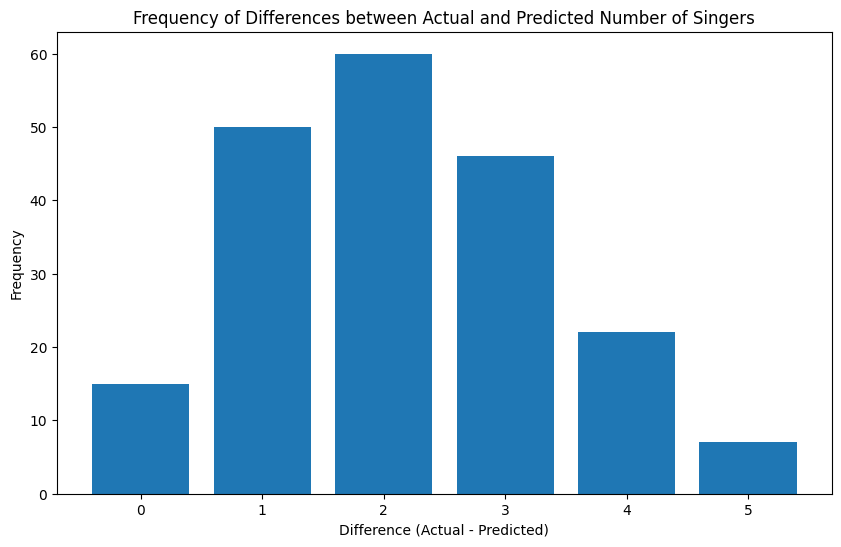

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(differences, counts)
plt.title('Frequency of Differences between Actual and Predicted Number of Singers')
plt.xlabel('Difference (Actual - Predicted)')
plt.ylabel('Frequency')
plt.xticks(differences)
plt.show()

In [ ]:
output_dir = os.path.join(base_dir, "RNN_ConcatenatedAudios2") # Directory to save the new audio file
pickle_file_path = os.path.join(output_dir, 'training_songs3.pkl')

with open(pickle_file_path, 'wb') as f:
  pickle.dump(np.array(training_songs3), f)
  print()

In [ ]:
import pickle

audio_path = '/content/drive/MyDrive/Pomona/ENGR208/AudioFiles/MedleyVox/RNN_ConcatenatedAudios2/training_songs3.pkl'

# Open the file and load the objects
with open(audio_path, 'rb') as file:
    training_songs3 = pickle.load(file)

In [ ]:
correct = 0
count = 0
for song in training_songs3:
  if song.num_singers == 2 and song.classification == 2:
    correct += 1
  if song.num_singers == 2:
    count += 1

print(correct / count * 100)

45.16129032258064
